## Deep Multi-Agent Reinforcement Learning 

Multi-agent setting: `Switch-n` environment from ma-gym. Please read [the wiki of ma-gym](https://github.com/koulanurag/ma-gym/wiki/) first.

### Environment Example
#### Switch2-v0
![Switch-2](https://raw.githubusercontent.com/koulanurag/ma-gym/master/static/gif/Switch2-v0.gif)
#### Switch4-v0
![Switch-4](https://raw.githubusercontent.com/koulanurag/ma-gym/master/static/gif/Switch4-v0.gif)

`Switch-n` is a grid world environment having `n agents` where each agent wants to move their corresponding home location (marked in boxes outlined in same colors).
Each agent receives only it's local position coordinates. The challenging part of the game is to pass through the narrow corridor through which only one agent can pass at a time. They need to coordinate to not block the pathway for the other. A reward of +5 is given to each agent for reaching their home cell. The episode ends when both agents has reached their home state or for a maximum of 100 steps in environment.

Action Space: `0: Down, 1: Left, 2: Up , 3: Right, 4: Noop`

Agent Observation : `Agent Coordinate + Steps in env.`

Best Score: `NA`

In [ ]:
%matplotlib inline
import gym
import ma_gym

Step 1: Identify a suitable baseline for learning one agent to reach its goal, by fixing the other agent. 

In [ ]:
import numpy as np

env = gym.make("Switch2-v0") 
episode_rewards = []
for episode_id in range(10000):
    ep_reward = 0
    obs_n = env.reset()
    done_n = [False for _ in range(env.n_agents)]
    timestep = 0
    while not done_n[0]:
        obs_n,reward_n,done_n,info = env.step([env.action_space.sample()[0],4])
        ep_reward += reward_n[0]
        timestep += 1
    episode_rewards.append(round(ep_reward,2))
    env.close()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
episode_rewards = np.asarray(episode_rewards)
print(f"In {round(((episode_rewards != -5).sum()/10000)*100,2)}% of episodes, one agent reached its goal (10,000 episodes).")

In 10.5% of episodes, one agent reached its goal (10,000 episodes).


In [ ]:
import copy
from collections import deque
from tqdm import tqdm
import random
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F

if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

In [ ]:
class Net(nn.Module):
    def __init__(self,agent_id,obs_space_len,action_space_len,hidden_size):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(obs_space_len,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,hidden_size)
        self.fc4 = nn.Linear(hidden_size,action_space_len)

    def forward(self,state):
        x = F.relu(self.fc1(state.to(DEVICE)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        q_vals = self.fc4(x)
        return q_vals 

class DQNAgent:
    def __init__(self,agent_id,obs_space_len,action_space_len,hidden_size):
        self.agent_id = agent_id
        self.policy_network = DuelingNet(agent_id,obs_space_len,action_space_len,hidden_size).double().to(DEVICE)
        self.target_network = copy.deepcopy(self.policy_network).to(DEVICE)
        self.optimiser = None
        self.epsilon = 0.8
        self.epsilon_decay = 0.999
        self.gamma = 0.95
        self.tau = 0.01
        self.action_num = action_space_len

    def take_action(self,state):
        if random.random() < self.epsilon:
            return np.random.choice(np.arange(0,self.action_num))
        else:
            return torch.argmax(self.policy_network(state)).item()

    def learn(self,state,action,reward,next_state,done):

        action = torch.tensor(action).long().to(DEVICE)
        next_state = torch.tensor(next_state).double().to(DEVICE)
        state = torch.tensor(state).double().to(DEVICE)
        next_Q,_ = torch.max(self.target_network(next_state),dim=1)
        done_tensor = torch.tensor(1-np.asarray(done)).to(DEVICE)
        target_Q = torch.tensor(reward).double().to(DEVICE) + self.gamma*next_Q.to(DEVICE)*done_tensor #calculate target Q-value
        Q_val = self.policy_network(torch.tensor(state).double())
        Q_val = Q_val[range(BATCH_SIZE),action.squeeze()]

        self.optimiser.zero_grad()
        loss = LOSS_FN(Q_val,target_Q.squeeze().to(DEVICE))
        loss.backward()
        self.optimiser.step()

        for target_param, local_param in zip(self.target_network.parameters(),self.policy_network.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

        return Q_val

In [ ]:
class Buffer:
    def __init__(self,size,n_agents):
        self.size = size
        self.buffers = {}
        for agent_id in range(n_agents):
            if agent_id not in self.buffers:
                self.buffers[agent_id] = deque(maxlen=size)
  
    def get_buffer(self,agent_id):
        return self.buffers[agent_id]

    def record_experience(self,agent_id,state,action,reward,next_state,done):
        self.buffers[agent_id].append({"s":state,"a":action,"r":reward,"next_s":next_state,"done":done})

    def sample(self,agent_id,batch_size):
        buffer = self.buffers[agent_id]
        experiences = random.sample(list(buffer),batch_size)
        states,actions,rewards,next_states,done = [],[],[],[],[]
        for experience in experiences:
            states.append(experience["s"])
            actions.append(experience["a"])
            rewards.append(experience["r"])
            next_states.append(experience["next_s"])
            done.append(experience["done"])

        return states,actions,rewards,next_states,done

In [ ]:
class DuelingNet(nn.Module):
    def __init__(self,agent_id,obs_space_len,action_space_len,hidden_size):
        super(DuelingNet,self).__init__()
        self.fc1 = nn.Linear(obs_space_len,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,hidden_size)
        self.V = nn.Linear(hidden_size,1)
        self.A = nn.Linear(hidden_size,action_space_len)

    def forward(self,state):
        x = F.relu(self.fc1(state.to(DEVICE)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        V = self.V(x)
        A = self.A(x)
        aggregate = V+(A-A.mean())
        return aggregate

In [ ]:
class PriorityBuffer(Buffer):
    def __init__(self,priority_degree,const,size,n_agents):
        super(PriorityBuffer,self).__init__(size,n_agents)
        self.priority_degree = priority_degree
        self.const = const
        self.probabilities_agents = [deque(maxlen=BUFFER_SIZE) for i in range(n_agents)]

    def record_experience(self,agent_id,state,action,reward,next_state,done):
        target_Q_dist = agents[agent_id].target_network(torch.tensor(next_state).double())
        target_Q = torch.max(target_Q_dist)
        Q_val = agents[agent_id].policy_network(torch.tensor(state).double())
        Q_val = Q_val[torch.tensor(action).long().squeeze()]
        p = ((torch.abs(torch.tensor(reward)+agents[agent_id].gamma*target_Q-Q_val)+self.const)**self.priority_degree).item()
        self.probabilities_agents[agent_id].append(p)
        self.buffers[agent_id].append({"s":state,"a":action,"r":reward,"next_s":next_state,"done":done,"priority":p})

    def sample(self,agent_id,batch_size):
        buffer = self.buffers[agent_id]
        probabilities = np.asarray(list(self.probabilities_agents[agent_id]))
        probabilities /= probabilities.sum()
        experiences = np.random.choice(np.asarray(list(buffer)),size=batch_size,replace=False,p=probabilities)
        states,actions,rewards,next_states,done = [],[],[],[],[]
        for experience in experiences:
            states.append(experience["s"])
            actions.append(experience["a"])
            rewards.append(experience["r"])
            next_states.append(experience["next_s"])
            done.append(experience["done"])

        return states,actions,rewards,next_states,done

In [ ]:
AGENTS_NUM = 2 
BUFFER_SIZE = int(1e5)
EPISODES_NUM = 2000
MAX_TIMESTEPS = 50
ACTION_SPACE_LEN = 5
OBS_SPACE_LEN = 2
TRAIN_EVERY = 4
HIDDEN_SIZE = 256
BATCH_SIZE = 64
LR = 0.001
WD = 0.0
PRIORITY_DEGREE = 0.5
CONST = 0.01

agents = []
for agent_id in range(AGENTS_NUM):
    agents.append(DQNAgent(agent_id,OBS_SPACE_LEN,ACTION_SPACE_LEN,HIDDEN_SIZE))
    agents[agent_id].optimiser = torch.optim.Adam(agents[agent_id].policy_network.parameters(),lr=LR,weight_decay=WD)

LOSS_FN = nn.MSELoss()

Step 2: Check DQN implementation by fixing one of the agents, and letting the other one to reach its destination.

In [ ]:
buffer = PriorityBuffer(PRIORITY_DEGREE,CONST,BUFFER_SIZE,AGENTS_NUM)
env = gym.make("Switch2-v0")
episode_rewards = []
reached_goal = []
for episode_id in range(EPISODES_NUM):
    state = env.reset() 
    episode_reward = 0
    train_every_count = 0 
    for timestep in range(MAX_TIMESTEPS):
        train_every_count += 1
        state_0,state_1 = state #observe state for both agents
        state_0 = torch.tensor(state_0).double()
        action_0 = agents[0].take_action(torch.tensor(state_0).double()) #use epsilon-greedy approach to take the next action by agent_0
        next_state,reward,done,_ = env.step([action_0,4]) #take a step (both agents) in the environment 
        buffer.record_experience(0,list(state_0),action_0,reward[0],next_state[0],done[0]) #record agent_0 experience in buffer
        episode_reward += reward[0] #update current episode reward, but only take into account the currently moving agent
        state = next_state #update the current state  

        #agent learning
        if (len(buffer.get_buffer(0)) > BATCH_SIZE) & (TRAIN_EVERY % train_every_count == 0):
            states,actions,rewards,next_states,done_0 = buffer.sample(0,BATCH_SIZE)
            agents[0].learn(states,actions,rewards,next_states,done_0)
            if agents[0].epsilon > 0.1:
                agents[0].epsilon *= agents[0].epsilon_decay

        if np.all(done[0]):
            print(f"Episode {episode_id+1} stopped after {timestep+1} timesteps. The reward for this episode is {round(episode_reward,2)}.")
            episode_rewards.append(episode_reward)
            break

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 1 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 2 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 3 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 4 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 5 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 6 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 7 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 8 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 9 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 10 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 11 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 12 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 13 stopped after 50 timesteps. The reward for this episode is -5.0.
Episode 14 stopped af

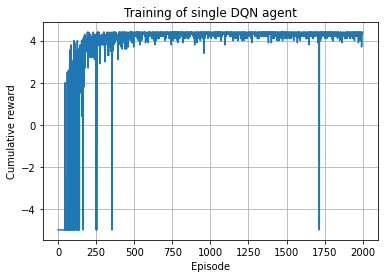

In [ ]:
plt.plot(episode_rewards)
plt.title("Training of single DQN agent")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.grid()
plt.show()

Step 3: Create a baseline with 2 agents taking random actions.

In [ ]:
import numpy as np

env = gym.make("Switch2-v0")
episode_rewards = []
for episode_id in range(10000):
    ep_reward = 0
    obs_n = env.reset()
    done_n = [False for _ in range(env.n_agents)]
    timestep = 0
    while not done_n[0]:
        obs_n,reward_n,done_n,info = env.step(env.action_space.sample())
        ep_reward += np.sum(reward_n)
        timestep += 1
    episode_rewards.append(round(ep_reward,2))
    env.close()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
episode_rewards = np.asarray(episode_rewards)
print(f"In {round(((episode_rewards > -10).sum()/10000)*100,2)}% of episodes, at least one agent reached its goal (10,000 episodes).")
print(f"In {round(((episode_rewards > 0).sum()/10000)*100,2)}% of episodes, both agents reached their goal (10,000 episodes).")

In 14.46% of episodes, at least one agent reached its goal (10,000 episodes).
In 1.61% of episodes, both agents reached their goal (10,000 episodes).


Step 4: Implement two individual Dueling DQN agents with Priority Experience Replay 

In [ ]:
#Environment-specific hyperparameters
AGENTS_NUM = 2 
EPISODES_NUM = 10000
MAX_TIMESTEPS = 50
ACTION_SPACE_LEN = 5
OBS_SPACE_LEN = 3
TRAIN_EVERY = 5

#Neural networks hyperparameters
HIDDEN_SIZE = 256
BATCH_SIZE = 64
LR = 0.0005
WD = 0.0

#Priority Experience Replay hyperparameters:
PRIORITY_DEGREE = 0.5
CONST = 0.05 #small constant used to make sure that no experiences have a zero probability of being selected
BUFFER_SIZE = int(1e5)

agents = []
for agent_id in range(AGENTS_NUM):
    agents.append(DQNAgent(agent_id,OBS_SPACE_LEN,ACTION_SPACE_LEN,HIDDEN_SIZE))
    agents[agent_id].optimiser = torch.optim.RMSprop(agents[agent_id].policy_network.parameters(),lr=LR,weight_decay=WD)

LOSS_FN = nn.MSELoss()

In [ ]:
buffer = PriorityBuffer(PRIORITY_DEGREE,CONST,BUFFER_SIZE,AGENTS_NUM)
env = gym.make("Switch2-v0")
episode_rewards = []
reached_goal = []
for episode_id in range(EPISODES_NUM):
    state = env.reset() 
    episode_reward = 0
    train_every_count = 0 
    reached = 0
    done = [False for i in range(AGENTS_NUM)]
    for timestep in range(MAX_TIMESTEPS):
        train_every_count += 1
        state_0,state_1 = state #observe state for both agents
        state_0 = torch.tensor(state_0+[timestep]).double()
        state_1 = torch.tensor(state_1+[timestep]).double()

        action_0 = agents[0].take_action(torch.tensor(state_0).double()) #use epsilon-greedy approach to take the next action by agent_0
        action_1 = agents[1].take_action(torch.tensor(state_1).double()) #use epsilon-greedy approach to take the next action by agent_1

        next_state,reward,done,_ = env.step([action_0,action_1]) #take a step (both agents) in the environment 

        buffer.record_experience(0,list(state_0),action_0,np.sum(reward),next_state[0]+[timestep+1],done[0]) #record agent_0 experience in buffer
        buffer.record_experience(1,list(state_1),action_1,np.sum(reward),next_state[1]+[timestep+1],done[1]) #record agent_1 experience in buffer
        episode_reward += np.sum(reward) #update current episode reward
        state = next_state #update the current state  

        #agent learning
        if (len(buffer.get_buffer(0)) > BATCH_SIZE) & (TRAIN_EVERY % train_every_count == 0):
            states,actions,rewards,next_states,done_0 = buffer.sample(0,BATCH_SIZE)
            agents[0].learn(states,actions,rewards,next_states,done_0)
            states,actions,rewards,next_states,done_1 = buffer.sample(1,BATCH_SIZE)
            agents[1].learn(states,actions,rewards,next_states,done_1)

        if (done[0]) & (reward[0] == 5):
            reached += 1
        if (done[1]) & (reward[1] == 5):
            reached += 1

        if np.all(done):
            print(f"Episode {episode_id+1} stopped after {timestep+1} timesteps. The reward for this episode is {round(episode_reward,2)}. {reached} agents reached their goal.")
            episode_rewards.append(episode_reward)
            reached_goal.append(reached)
            break

    if agents[0].epsilon > 0.01:
        agents[0].epsilon *= agents[0].epsilon_decay
    else:
        agents[0].epsilon = 0.01

    if agents[1].epsilon > 0.01:
        agents[1].epsilon *= agents[1].epsilon_decay
    else:
        agents[1].epsilon = 0.01

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 1 stopped after 50 timesteps. The reward for this episode is -10.0. 0 agents reached their goal.
Episode 2 stopped after 50 timesteps. The reward for this episode is -10.0. 0 agents reached their goal.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Streaming output truncated to the last 5000 lines.
Episode 5001 stopped after 17 timesteps. The reward for this episode is 6.8. 2 agents reached their goal.
Episode 5002 stopped after 17 timesteps. The reward for this episode is 6.8. 2 agents reached their goal.
Episode 5003 stopped after 18 timesteps. The reward for this episode is 6.6. 2 agents reached their goal.
Episode 5004 stopped after 17 timesteps. The reward for this episode is 6.8. 2 agents reached their goal.
Episode 5005 stopped after 17 timesteps. The reward for this episode is 6.8. 2 agents reached their goal.
Episode 5006 stopped after 50 timesteps. The reward for this episode is -4.9. 1 agents reached their goal.
Episode 5007 stopped after 21 timesteps. The reward for this episode is 6.0. 2 agents reached their goal.
Episode 5008 stopped after 17 timesteps. The reward for this episode is 6.8. 2 agents reached their goal.
Episode 5009 stopped after 17 timesteps. The reward for this episode is 6.8. 2 agents reached their 

In [ ]:
def moving_average(array,period):
    ma_array = []
    for i in range(period,len(array)):
        ma_array.append(np.asarray(array)[i:period+i].mean())
    return ma_array

Step 5: Check the performance of two trained agents over 10,000 episodes.

In [ ]:
import numpy as np

agents[0].epsilon = 0
agents[1].epsilon = 0

env = gym.make("Switch2-v0")
test_rewards = [] 
for episode_id in range(10000):
    ep_reward = 0
    obs_n = env.reset()
    done_n = [False for _ in range(env.n_agents)]
    timestep = 0
    while not done_n:
        action_0 = agents[0].take_action(torch.tensor(obs_n[0]+[timestep]).double())
        action_1 = agents[1].take_action(torch.tensor(obs_n[1]+[timestep]).double())
        obs_n,reward_n,done_n,info = env.step([action_0,action_1])
        ep_reward += np.sum(reward_n)
        timestep += 1
    test_rewards.append(round(ep_reward,2))
    env.close()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
test_rewards = np.asarray(test_rewards)
print(f"In {round(((test_rewards > -10).sum()/10000)*100,2)}% of episodes, at least one agent reached its goal (10,000 episodes).")
print(f"In {round(((test_rewards > 0).sum()/10000)*100,2)}% of episodes, both agents reached their goal (10,000 episodes).")

In 100.0% of episodes, at least one agent reached its goal (10,000 episodes).
In 100.0% of episodes, both agents reached their goal (10,000 episodes).


#### Plot the Learning Curve

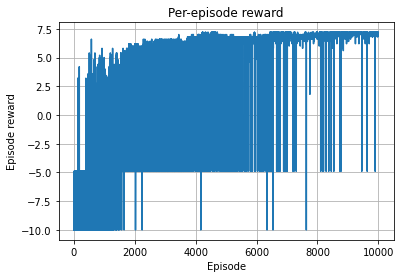

In [ ]:
plt.plot(episode_rewards)
plt.title("Per-episode reward")
plt.xlabel("Episode")
plt.ylabel("Episode reward")
plt.grid()

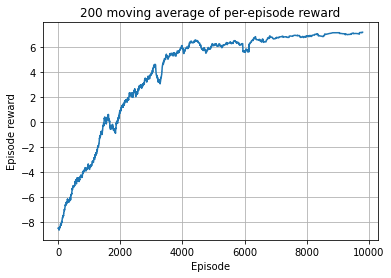

In [ ]:
MA_WINDOW = 200
plt.plot(moving_average(episode_rewards,MA_WINDOW))
plt.title(f"{MA_WINDOW} moving average of per-episode reward")
plt.xlabel("Episode")
plt.ylabel("Episode reward")
plt.grid()

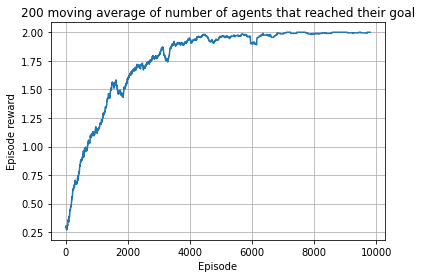

In [ ]:
plt.plot(moving_average(reached_goal,MA_WINDOW))
plt.title(f"{MA_WINDOW} moving average of number of agents that reached their goal")
plt.xlabel("Episode")
plt.ylabel("Episode reward")
plt.grid()

#### Analysis on performance

My approach to training agents to solve Switch2-v0 game involved a few key steps. At first, I fixed one of the two agents to its starting position, and let the other take random actions to achieve its destination. In approximately 10-11% of episodes (10,000 episodes in total), one agent managed to get to its final destination in at most 50 steps. Then, I implemented a Deep Q-learning Network (DQN) agent with a couple of commonly-used modifications often used to stabilise and improve training, namely the target network, priority experience replay, dueling networks. For the single-agent scenario, that was sufficient to achieve convergence in a few hundred epochs. The success in training a single agent confirmed that my implementation of DQN was correct, and I used two Dueling DQN agents with priority experience replay (PER) to solve the Switch2-v0 environment. On top of the mentioned techniques to improve DQN performance, I have also added the "FingerPrinting" method (paper: <a href=https://arxiv.org/abs/1702.08887>Stabilising Experience Replay for Deep Multi-Agent Reinforcement Learning</a>), which involved adding a timestep to the observation array for each agent, which helped agents to identify where along the training trajectory, the experience sampled from the PER is coming from. Also, after unsuccessfully training agents by passing only their individual rewards, I altered the code to allow both agents to receive their shared reward, which resulted in solving the environment. This is possible since the agents act in a cooperative environment. Although the Independent Learning approach is the simplest amongst multi-agent reinforcement learning (MARL) solutions, it is often sufficient to achieve competitive results (paper: <a href=https://arxiv.org/abs/2006.07869> Comparative Evaluation of Multi-Agent Deep Reinforcement Learning Algorithms</a>). In the case of the studied environment (Switch2-v0), indepedent DQN solution achieved the desired performance in terms of agents consistently reaching their destinations, however the converged number of steps taken by both agents (15 steps) is not minimal, and there is a potential for further improvement of the results. 

After around 4,000-5,000 episodes both agents reached convergence, and consistently solved the environment in a few steps. I tested the trained agents against the random baseline, and in 100% of episodes (10,000 episodes in total), both agents reached their destinations, whereas in the case of the random baseline only in 1.6% of episodes, both agents reached their destinations (10,000 episodes in total). 


## Switch v4 Game

In [ ]:
AGENTS_NUM = 4
BUFFER_SIZE = int(1e5)
EPISODES_NUM = 20000
MAX_TIMESTEPS = 50
ACTION_SPACE_LEN = 5
OBS_SPACE_LEN = 3
TRAIN_EVERY = 5
HIDDEN_SIZE = 256
BATCH_SIZE = 64
LR = 0.0005
WD = 0.0
EPSILON = 1
EPSILON_DECAY = 0.9995
PRIORITY_DEGREE = 0.5
CONST = 0.05

agents = []
for agent_id in range(AGENTS_NUM):
    agents.append(DQNAgent(agent_id,OBS_SPACE_LEN,ACTION_SPACE_LEN,HIDDEN_SIZE))
    agents[agent_id].optimiser = torch.optim.RMSprop(agents[agent_id].policy_network.parameters(),lr=LR,weight_decay=WD)
    agents[agent_id].epsilon = EPSILON
    agents[agent_id].epsilon_decay = EPSILON_DECAY

LOSS_FN = nn.MSELoss()

In [ ]:
buffer = PriorityBuffer(PRIORITY_DEGREE,CONST,BUFFER_SIZE,AGENTS_NUM)
env = gym.make("Switch4-v0")
episode_rewards = []
reached_goal = []
for episode_id in range(EPISODES_NUM):
    state = env.reset() 
    episode_reward = 0
    train_every_count = 0 
    reached = 0
    done = [False for i in range(AGENTS_NUM)]
    for timestep in range(MAX_TIMESTEPS):
        train_every_count += 1
        state_0,state_1,state_2,state_3 = state

        state_0 = torch.tensor(state_0+[timestep]).double()
        state_1 = torch.tensor(state_1+[timestep]).double()
        state_2 = torch.tensor(state_2+[timestep]).double()
        state_3 = torch.tensor(state_3+[timestep]).double()

        action_0 = agents[0].take_action(torch.tensor(state_0).double()) #use epsilon-greedy approach to take the next action by agent_0
        action_1 = agents[1].take_action(torch.tensor(state_1).double()) #use epsilon-greedy approach to take the next action by agent_1
        action_2 = agents[2].take_action(torch.tensor(state_2).double()) #use epsilon-greedy approach to take the next action by agent_2
        action_3 = agents[3].take_action(torch.tensor(state_3).double()) #use epsilon-greedy approach to take the next action by agent_3

        next_state,reward,done,_ = env.step([action_0,action_1,action_2,action_3]) #take a step (both agents) in the environment 

        buffer.record_experience(0,list(state_0),action_0,np.sum(reward),next_state[0]+[timestep+1],done[0]) #record agent_0 experience in buffer
        buffer.record_experience(1,list(state_1),action_1,np.sum(reward),next_state[1]+[timestep+1],done[1]) #record agent_1 experience in buffer
        buffer.record_experience(2,list(state_2),action_2,np.sum(reward),next_state[2]+[timestep+1],done[2]) #record agent_2 experience in buffer
        buffer.record_experience(3,list(state_3),action_3,np.sum(reward),next_state[3]+[timestep+1],done[3]) #record agent_3 experience in buffer
        episode_reward += np.sum(reward) #update current episode reward
        state = next_state #update the current state  

        #agent learning
        if (len(buffer.get_buffer(0)) > BATCH_SIZE) & (TRAIN_EVERY % train_every_count == 0):
            states_0,actions_0,rewards_0,next_states_0,done_0 = buffer.sample(0,BATCH_SIZE)
            states_1,actions_1,rewards_1,next_states_1,done_1 = buffer.sample(1,BATCH_SIZE)
            states_2,actions_2,rewards_2,next_states_2,done_2 = buffer.sample(2,BATCH_SIZE)
            states_3,actions_3,rewards_3,next_states_3,done_3 = buffer.sample(3,BATCH_SIZE)

            agents[0].learn(states_0,actions_0,rewards_0,next_states_0,done_0)
            agents[1].learn(states_1,actions_1,rewards_1,next_states_1,done_1)
            agents[2].learn(states_2,actions_2,rewards_2,next_states_2,done_2)
            agents[3].learn(states_3,actions_3,rewards_3,next_states_3,done_3)

        if (done[0]) & (reward[0] == 5):
            reached += 1
        if (done[1]) & (reward[1] == 5):
            reached += 1
        if (done[2]) & (reward[2] == 5):
            reached += 1
        if (done[3]) & (reward[3] == 5):
            reached += 1

        if np.all(done):
            print(f"Episode {episode_id+1} stopped after {timestep+1} timesteps. The reward for this episode is {round(episode_reward,2)}. {reached} agents reached their goal.")
            episode_rewards.append(episode_reward)
            reached_goal.append(reached)
            break

    if agents[0].epsilon > 0.01:
        agents[0].epsilon *= agents[0].epsilon_decay
    else:
        agents[0].epsilon = 0.01

    if agents[1].epsilon > 0.01:
        agents[1].epsilon *= agents[1].epsilon_decay
    else:
        agents[1].epsilon = 0.01

    if agents[2].epsilon > 0.01:
        agents[2].epsilon *= agents[2].epsilon_decay
    else:
        agents[2].epsilon = 0.01

    if agents[3].epsilon > 0.01:
        agents[3].epsilon *= agents[3].epsilon_decay
    else:
        agents[3].epsilon = 0.01

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7

Episode 15001 stopped after 50 timesteps. The reward for this episode is -4.7. 3 agents reached their goal.
Episode 15002 stopped after 50 timesteps. The reward for this episode is -4.7. 3 agents reached their goal.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 15003 stopped after 50 timesteps. The reward for this episode is -4.7. 3 agents reached their goal.
Episode 15004 stopped after 50 timesteps. The reward for this episode is -4.7. 3 agents reached their goal.
Episode 15005 stopped after 50 timesteps. The reward for this episode is -4.7. 3 agents reached their goal.
Episode 15006 stopped after 50 timesteps. The reward for this episode is -4.7. 3 agents reached their goal.
Episode 15007 stopped after 50 timesteps. The reward for this episode is -4.7. 3 agents reached their goal.
Episode 15008 stopped after 50 timesteps. The reward for this episode is -4.7. 3 agents reached their goal.
Episode 15009 stopped after 50 timesteps. The reward for this episode is -4.7. 3 agents reached their goal.
Episode 15010 stopped after 50 timesteps. The reward for this episode is -4.7. 3 agents reached their goal.
Episode 15011 stopped after 50 timesteps. The reward for this episode is -14.9. 1 agents reached their goal.
Episode 15012 stopped after

Check the performance of four trained agents in the Switch4-v0 environment.

In [ ]:
agents[0].epsilon = 0
agents[1].epsilon = 0
agents[2].epsilon = 0
agents[3].epsilon = 0

env = gym.make("Switch4-v0")
test_rewards = [] 
for episode_id in range(10000):
    ep_reward = 0
    obs_n = env.reset()
    done_n = [False for _ in range(env.n_agents)]
    timestep = 0
    while not np.all(done_n):
        action_0 = agents[0].take_action(torch.tensor(obs_n[0]+[timestep]).double())
        action_1 = agents[1].take_action(torch.tensor(obs_n[1]+[timestep]).double())
        action_2 = agents[2].take_action(torch.tensor(obs_n[2]+[timestep]).double())
        action_3 = agents[3].take_action(torch.tensor(obs_n[3]+[timestep]).double())
        obs_n,reward_n,done_n,info = env.step([action_0,action_1,action_2,action_3])
        ep_reward += np.sum(reward_n)
        timestep += 1
    test_rewards.append(round(ep_reward,2))
    env.close()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
test_rewards = np.asarray(test_rewards)
print(f"In {round(((test_rewards > -20).sum()/10000)*100,2)}% of episodes, at least one agent reached its goal (10,000 episodes).")
print(f"In {round(((test_rewards > -14.9).sum()/10000)*100,2)}% of episodes, at least two agents reached their goal (10,000 episodes).")
print(f"In {round(((test_rewards > -4.9).sum()/10000)*100,2)}% of episodes, at least three agents reached their goal (10,000 episodes).")
print(f"In {round(((test_rewards > 0).sum()/10000)*100,2)}% of episodes, all four agents reached their goal (10,000 episodes).")

In 100.0% of episodes, at least one agent reached its goal (10,000 episodes).
In 100.0% of episodes, at least two agents reached their goal (10,000 episodes).
In 100.0% of episodes, at least three agents reached their goal (10,000 episodes).
In 0.0% of episodes, all four agents reached their goal (10,000 episodes).


#### Plot the Learning Curve

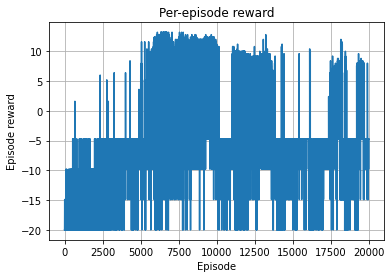

In [ ]:
plt.plot(episode_rewards)
plt.title("Per-episode reward")
plt.xlabel("Episode")
plt.ylabel("Episode reward")
plt.grid()

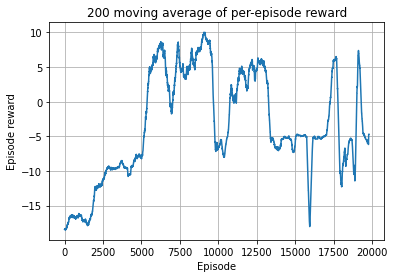

In [ ]:
MA_WINDOW = 200
plt.plot(moving_average(episode_rewards,MA_WINDOW))
plt.title(f"{MA_WINDOW} moving average of per-episode reward")
plt.xlabel("Episode")
plt.ylabel("Episode reward")
plt.grid()

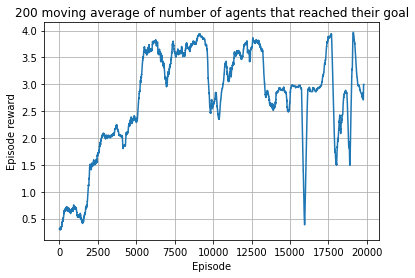

In [ ]:
plt.plot(moving_average(reached_goal,MA_WINDOW))
plt.title(f"{MA_WINDOW} moving average of number of agents that reached their goal")
plt.xlabel("Episode")
plt.ylabel("Episode reward")
plt.grid()

#### Analysis on Performance

In cooperative multi-agent learning environments where agents receive shared reward, the issue of non-stationarity might give a rise to unwanted behaviour. For the Switch2-v0 game, two independent dueling DQN agents learnt their individual policies that allowed both agents to reach their destinations in a limited number of steps. However, in the Switch4-v0 game, there are now four agents, which increases the complexity of the game, and after carrying out a number of tests involving training four dueling DQN agents with shared reward, the training showed to be difficult to converge to all 4 agents consistently reaching their goals. However, at least 3 agents consistently reached their destinations during training, with the exception of a few drops in performance throughout the training process. During testing with epsilon value set to 0, 3 agents reached their destinations in 100% out of 10,000 testing episodes. 

To further improve the independent learning approach, some form of value decomposition solution, for example Value-Decomposition Network (VDN) or QMIX could be used to address the issue with unexplained influences on the total reward from the view of individual agents. After implementing the VDN solution, the results did not improve, and I decided to keep the results of the independent DQN implementation. In comparison to the Switch2-v0 environment, I found that similar hyperparameters worked best for the Switch4-v0 case. However, to allow more time for agents' exploration, I increased the value of the epsilon decay to 0.9995, and after it reaches 0.01 it was flat until the end of the training. Also, I increased the number of training episodes to be more confident in the learning curve. Other alterations such as a lower learning rate of a RMSprop optimiser and larger hidden layers of individual agents did not seem to have a positive effect on training.